CMI-based attribution method faithfulness evaluation pipeline
---
This notebooks provides the complete CMI-based attribution method faithfulness evaluation pipeline. It contains the following functionalities:
- Load dataset
- Load model
- Generate explanations with selected attribution and perturbation methods
- Compute faithfulnesss of attribution methods


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports and Constants

In [4]:
from tsai.all import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from fastai.callback.tracker import SaveModelCallback
import sklearn.metrics as skm
import seaborn as sn
import torch.nn as nn

from  sklearn import preprocessing

from utils.utils import *

In [5]:
print('is cuda available: ', torch.cuda.is_available())
print('number of devices: ', torch.cuda.device_count())
print('GPU name: ', torch.cuda.get_device_name(0))
print('Memory Usage:')
print('- Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('- Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


is cuda available:  True
number of devices:  1
GPU name:  NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
- Allocated: 0.0 GB
- Cached:    0.0 GB


## Dataset

### Load dataset

Dataset id:  FordA
  #Samples:   1319
  #Classes:   2
  #Channels:  1
  Length:    500


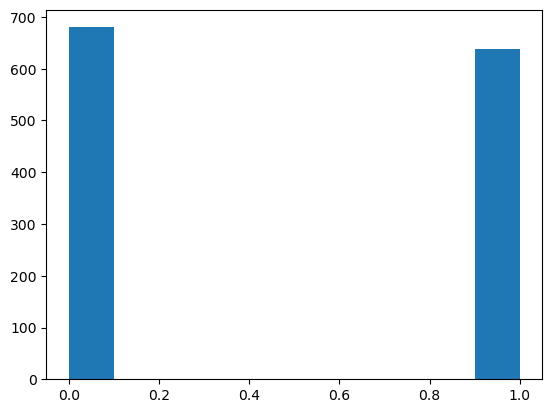

In [6]:
# DSID = 'Epilepsy' 
# try:
#     X, y  = load_multivariate_UCR_dataset(DSID, is_testset=True)
# except:
#     print('! Could not fetch dataset "{}"'.format(DSID))
# class_mapping_dict = { # alphabetical order
#     'EPILEPSY' : 0,
#     'RUNNING' : 1,
#     'SAWING' : 2,
#     'WALKING' : 3,
# }
# y = np.array([class_mapping_dict[label] for label in y])

DSID = 'FordA'
# DSID = 'NonInvasiveFetalECGThorax1'
# DSID = 'Wafer'
try:
    X, y, _  = load_univariate_UCR_dataset(DSID, is_testset=True)
except:
    print('! Could not fetch dataset "{}"'.format(DSID))


sample_length = X.shape[2]
num_channels = X.shape[1]
num_classes = len(np.unique(y))

print('Dataset id: ', DSID)
print('  #Samples:  ', X.shape[0])
print('  #Classes:  ', num_classes)
print('  #Channels: ', num_channels)
print('  Length:   ', sample_length)

plt.hist(y) # plot sample distribution over classes
plt.show()

### Init and load model

In [7]:
from utils.resnetmulti import ResNetMulti
from utils.resnet import ResNet
from utils.mlp import MLP

if DSID == 'Epilepsy':
    try:
        model = ResNetMulti(sample_length, num_channels, num_classes)
        state_dict = torch.load("models\Epilepsy\Epilepsy_resnet_multi.pt", map_location=device)
        model.load_state_dict(state_dict)
        model = model.to(device)
        model.eval()
        print('Epilepsy model loaded!')
    except:
        print('Could not load model...')
elif DSID == 'FordA':
    try:
        model = ResNet(sample_length, num_channels, num_classes)
        state_dict = torch.load("models\FordA\ResNet\model.pt", map_location=device)
        model.load_state_dict(state_dict)

        # model = MLP(sample_length, num_channels, num_classes)
        # state_dict = torch.load("models\FordA\MLP\model.pt", map_location=device)
        # model.load_state_dict(state_dict)

        model = model.to(device)
        model.eval()
        print('FordA model loaded!')
    except:
        print('Could not load model...')

elif DSID == 'NonInvasiveFetalECGThorax1':
    try:
        model = ResNet(sample_length, num_channels, num_classes)
        state_dict = torch.load("models/NonInvasiveFetalECGThorax1/ResNet/model.pt", map_location=device)
        model.load_state_dict(state_dict)

        model = model.to(device)
        model.eval()
        print('NonInvasiveFetalECGThorax1 model loaded!')
    except:
        print('Could not load model...')

elif DSID == 'Wafer':
    try:
        model = ResNet(sample_length, num_channels, num_classes)
        state_dict = torch.load("models/Wafer/ResNet/model.pt", map_location=device)
        model.load_state_dict(state_dict)

        model = model.to(device)
        model.eval()
        print('Wafer model loaded!')
    except:
        print('Could not load model...')

FordA model loaded!


### Calculate accuracy of model

In [ ]:
X_tensor = torch.Tensor(X).to(device)
y_tensor = torch.Tensor(y).to(device)

with torch.no_grad():  # Disable gradient computation
    outputs = model(X_tensor)
    # Get predicted class labels (assuming classification task)
    _, predicted = torch.max(outputs, 1)
    # Calculate the number of correct predictions
    correct = (predicted == y_tensor).sum().item()
    # Compute accuracy
    accuracy = correct / y_tensor.size(0)

del X_tensor
del y_tensor
torch.cuda.empty_cache()
accuracy

0.9401061410159212

# Compute DDS and PES scores for attribution methods

In [9]:
from utils.subsequence_perturbation_multivariate import SubSequencePerturber as ssp
from utils.res_utils import compute_dataset_dds, pes, CMI
import copy

from interpretability_methods.interpretability_methods import (
    InputXGradientCaptum,
    IntegratedGradientsCaptum,
    DeepLIFTCaptum,
    FeatureAblationCaptum,
    SaliencyCaptum,
    GuidedBackpropCaptum,
    DeconvolutionCaptum,
    KernelShapCaptum,
    LimeCaptum,
    RandomAttribution,
    GradCAM,
    GuidedGradCAMCaptum
)

perturbations_methods = [
    # ---- TEST SUBSET ----
    # ssp.Zero,
    # ssp.Laplace,
    # ssp.GaussianBlur,
    # ssp.Padding

    # ---- ALL ----
    ssp.UniformNoise100,
    ssp.UniformNoise75,
    ssp.UniformNoise50,
    ssp.UniformNoise25,
    ssp.SampleMean,
    ssp.GaussianBlur,
    ssp.Laplace,
    ssp.SavitzkyGolay,
    ssp.Zero,
    ssp.Inverse,
    ssp.Swap,
    ssp.SubsequenceMean,
    ssp.OutOfDistHigh,
    ssp.OutOfDistLow,
    ssp.LinearInterpolation,
    ssp.QuadraticInterpolation,
    ssp.CubicInterpolation,
    ssp.Padding,
    ssp.Nearest,
    ssp.LeftNeighborWindow,
    ssp.RightNeighborWindow,
    ssp.NearestNeighborWindow,
    ssp.SimilarNeighborWindow,
    ssp.DissimilarNeighborWindow
]

attribution_methods = [
    InputXGradientCaptum,
    IntegratedGradientsCaptum,
    DeepLIFTCaptum,
    FeatureAblationCaptum,
    SaliencyCaptum,
    GuidedBackpropCaptum,
    DeconvolutionCaptum,
    RandomAttribution,
    KernelShapCaptum,
    LimeCaptum,
    GradCAM,
    GuidedGradCAMCaptum,
]

batch_size = 256
region_size_percent = 2.5
perturbation_percentage = 0.5

In [10]:
def adapt_batch_size_to_am(attribution_method):
    '''Returns the highest possible batch size given the attribution method that still fits into VRAM (default 64)

    The values below were empirically selected for a GPU with 4GB of VRAM (3050ti)
    Different values may be better for different models and datasets and GPUs

    Parameters:
        attribution_method (object): the attribution method for which the batch size should be returned

    Returns:
        batch size (int)
    '''
    try:
        attribution_method_name = attribution_method.__name__
    except:
        attribution_method_name = attribution_method

    if attribution_method_name == 'GradCAM':
        return 512
    elif attribution_method_name == 'GuidedGradCAMCaptum':
        return 256
    elif attribution_method_name == 'IntegratedGradientsCaptum':
        return 128
    elif attribution_method_name == 'KernelShapCaptum':
        return 1
    elif attribution_method_name == 'LimeCaptum':
        return 1
    elif attribution_method_name == 'SaliencyCaptum':
        return 256
    elif attribution_method_name == 'DeepLIFTCaptum':
        return 128
    elif attribution_method_name == 'InputXGradientCaptum':
        return 256
    elif attribution_method_name == 'GuidedBackpropCaptum':
        return 256
    elif attribution_method_name == 'DeconvolutionCaptum':
        return 256
    elif attribution_method_name == 'FeatureAblationCaptum':
        return 32 
    else:
        return 64 # default case
    

def compute_faithfulness_metrics(model, data_x, data_y, attribution_method, perturbation_method, explainer):
    
    # prepare results array
    results = []
    for s_idx in range(0, len(data_x), batch_size):

        target_samples = np.array(data_x[s_idx:s_idx+batch_size], copy=True)
        target_labels = data_y[s_idx:s_idx+batch_size].astype(np.int64)
        sample_indexes = np.arange(s_idx, s_idx+len(target_samples))

        x_batch = torch.tensor(target_samples, dtype=torch.float32).requires_grad_(True)
        x_batch = x_batch.to(device)

        # make initial prediction
        with torch.no_grad():
            model_output = model(x_batch)

        if device.type == 'cuda':
            raw_output = torch.exp(model_output).squeeze().cpu().detach().numpy()
        else:
            raw_output = torch.exp(model_output).squeeze().detach().numpy()

        if len(raw_output.shape) == 1:
            raw_output = raw_output.reshape(1, -1)
        probabilities_mask = np.zeros_like(raw_output)
        for i in range(len(probabilities_mask)):
            probabilities_mask[i][target_labels[i]] = 1
        probabilities = raw_output[probabilities_mask == 1]

        input_relevances = np.zeros(x_batch.shape)

        target = torch.tensor(target_labels)
        target = target.to(device)

        # compute attributions using am adapted batch-size (to not exhaust gpu memory with memory hungry AMs)
        attributions = torch.zeros_like(x_batch)
        bs = adapt_batch_size_to_am(explainer)
        for a_idx in range(0, x_batch.shape[0], bs):
            attributions[a_idx:a_idx+bs] = explainer.attribute(x_batch[a_idx:a_idx+bs], target=target[a_idx:a_idx+bs])

        # after finishing calculations with tensors on gpu, move the data back to the cpu and free all gpu memory!
        if device.type == 'cuda':
            attributions = attributions.cpu().detach().numpy()
        else:
            attributions = attributions.detach().numpy()

        for i in range(len(x_batch)):
            attribution = attributions[i]  # .unsqueeze(0)
            min_val = attribution.min()
            max_val = attribution.max()
            if (max_val - min_val) != 0:
                attribution = (attribution - min_val) / float(max_val - min_val)
            elif max_val != 0:
                attribution = attribution / max_val
            input_relevances[i] = attribution

        input_length = x_batch.shape[-1]

        rs = round(input_length * region_size_percent / 100)
        region_size = rs

        num_regions = math.ceil(input_length / rs)
        
        # divide samples by regions and determine morf and lerf order in which the regions should be perturbed
        relevance_orders = []

        if (input_length % region_size) > 0:
            n_pad_elements = region_size - (input_length % region_size)
            padded = np.pad(attributions, ( (0,0), (0,0),  (0, n_pad_elements) ), mode='edge')
            padded = padded.reshape(padded.shape[0], padded.shape[1], num_regions, region_size)

            mean_region_relevances = np.mean(padded, axis=3)
        else: # we don't need to pad, since the input length is divisible by the region size
            r_attributions = attributions.reshape(attributions.shape[0], attributions.shape[1], num_regions, region_size)
            mean_region_relevances = np.mean(r_attributions, axis=3)

        repeated_mean_region_relevances = np.repeat(mean_region_relevances, region_size, axis=2) # nice-to-have for debugging - to plot averaged attribution maps
        repeated_mean_region_relevances = repeated_mean_region_relevances[:,:,:input_length] # nice-to-have for debugging - to plot averaged attribution maps

        unrolled_mean_region_relevances = mean_region_relevances.reshape(mean_region_relevances.shape[0], -1) # flatten the averaged relevances
        unrolled_ordered_regions_by_relevance = np.argsort(unrolled_mean_region_relevances) # sort them (default is ascending) -> from least to most important
        unrolled_ordered_regions_by_relevance = np.flip(unrolled_ordered_regions_by_relevance, axis=-1) # flip order -> from most to least important

        for i in range(len(input_relevances)):
            rel_points = unrolled_ordered_regions_by_relevance[i]

            relevance_orders.append({
                'MoRF': rel_points,
                'LeRF': np.flip(np.array(rel_points, copy=True)),
            })

        # prepare results object
        results_objs = []
        for i in range(len(sample_indexes)):
            results_objs.append({
                'input relevances': input_relevances[i].tolist(),
                'perturbation results': {
                    'MoRF': [],
                    'LeRF': []
                }
            })

        actual_num_of_perturbation_steps = math.floor(unrolled_ordered_regions_by_relevance.shape[1] * perturbation_percentage)

        # perform perturbations
        for order in relevance_orders[0]:
            predictions = np.zeros((len(target_samples), actual_num_of_perturbation_steps+1)
                                )  # add 1 to number of regions to store initial prediction

            samples_batch = copy.deepcopy(target_samples)
            samples_tensor = torch.tensor(samples_batch, dtype=torch.float32)
            if device.type == 'cuda':
                samples_tensor = samples_tensor.cuda()

            with torch.no_grad():
                output = torch.exp(model(samples_tensor)).squeeze()

            if device.type == 'cuda':
                raw_output = output.cpu().numpy()
            else:
                raw_output = output.numpy()
            if len(raw_output.shape) == 1:
                raw_output = raw_output.reshape(1, -1)

            probabilities_mask = np.zeros_like(raw_output)
            for i in range(len(probabilities_mask)):
                # probabilities_mask[i][predicted_labels[i]] = 1
                probabilities_mask[i][target_labels[i]] = 1
            probabilities = raw_output[probabilities_mask == 1] * 100

            predictions[:, 0] = probabilities

            perturbers = []
            for i in range(len(samples_batch)):
                perturbers.append(perturbation_method(samples_batch[i]))

            for perturbation_step in range(actual_num_of_perturbation_steps):
                # Perturb the n-th step in all samples
                for i in range(len(samples_batch)):
                    unrolled_region_index = relevance_orders[i][order][perturbation_step]
                    channel_idx = unrolled_region_index // mean_region_relevances.shape[-1]
                    region_idx = unrolled_region_index % mean_region_relevances.shape[-1]

                    start = region_idx * rs
                    end = (region_idx + 1) * rs

                    if start < 0:
                        start = 0
                    if end >= input_length - 1:
                        end = input_length - 1

                    perturbed_sample = perturbers[i].perturb_subsequence(start, end, channel=channel_idx)
                    samples_batch[i] = perturbed_sample

                perturbed_batch = torch.tensor(samples_batch, dtype=torch.float32)
                if device.type == 'cuda':
                    perturbed_batch = perturbed_batch.cuda()

                with torch.no_grad():
                    output = torch.exp(model(perturbed_batch)).squeeze()

                if device.type == 'cuda':
                    raw_output = output.cpu().numpy()
                else:
                    raw_output = output.numpy()

                if len(raw_output.shape) == 1:
                    raw_output = raw_output.reshape(1, -1)

                probabilities_mask = np.zeros_like(raw_output)
                for i in range(len(probabilities_mask)):
                    probabilities_mask[i][target_labels[i]] = 1
                probabilities = raw_output[probabilities_mask == 1] * 100

                predictions[:, perturbation_step+1] = probabilities  # always +1 since the first position is the initial predictions

            del samples_batch
            del perturbed_sample
            del perturbed_batch

            for i in range(len(sample_indexes)):
                results_objs[i]['perturbation results'][order] = predictions[i].tolist()
        results += results_objs

    # Compute the decaying degradation score and perturbation effect size
    morf_pcs = []
    lerf_pcs = []
    for res in results:
        morf_pcs.append(res['perturbation results']['MoRF'])
        lerf_pcs.append(res['perturbation results']['LeRF'])

    dds_values = compute_dataset_dds(morf_pcs, lerf_pcs)
    pes_score = pes(dds_values)

    dds_score = dds_values.mean()
    cmi_score = CMI(dds_score,pes_score)
    
    torch.cuda.empty_cache()

    return dds_score, pes_score, cmi_score

In [ ]:
results_dicts = []
for attribution_method in attribution_methods:
    am_name = attribution_method.__name__.replace('Captum','')
    explainer = attribution_method(model)
    print(am_name)
    for perturbation_method in perturbations_methods:
        pm_name = perturbation_method.__name__
        dds_score, pes_score, cmi_score = compute_faithfulness_metrics(model, X, y, attribution_method, perturbation_method, explainer)
        print('  {:<20} | DDS: {:.3f} | PES: {:.3f} | CMI: {:.3f}'.format(pm_name, dds_score, pes_score, cmi_score))
        results_dicts.append({
            'AM': am_name,
            'PM': pm_name,
            'DDS': dds_score,
            'PES': pes_score,
            'CMI': cmi_score
        })

results_df = pd.DataFrame(results_dicts)
results_df

,AM,PM,DDS,PES,CMI
0,InputXGradient,UniformNoise100,0.005051,0.059894,0.009316
1,InputXGradient,UniformNoise75,0.005530,0.065959,0.010204
2,InputXGradient,UniformNoise50,0.005889,0.038666,0.010221
3,InputXGradient,UniformNoise25,0.005221,0.056861,0.009564
4,InputXGradient,SampleMean,0.080327,0.783169,0.145709
...,...,...,...,...,...
283,GuidedGradCAM,LeftNeighborWindow,-0.040179,-0.351024,0.072105
284,GuidedGradCAM,RightNeighborWindow,-0.031938,-0.234268,0.056212
285,GuidedGradCAM,NearestNeighborWindow,-0.009386,-0.302502,0.018208
286,GuidedGradCAM,SimilarNeighborWindow,-0.032232,-0.284306,0.057899


In [11]:
#results_df.to_csv('FordA-ResNet-trained-model-all-ams-pms.csv', index=False) # optionally store the results as csv

In [12]:
# results_df = pd.read_csv('FordA-ResNet-trained-model-all-ams-pms.csv') # load stored results from csv
# results_df

### Compute cmi_max per PM across all AMs

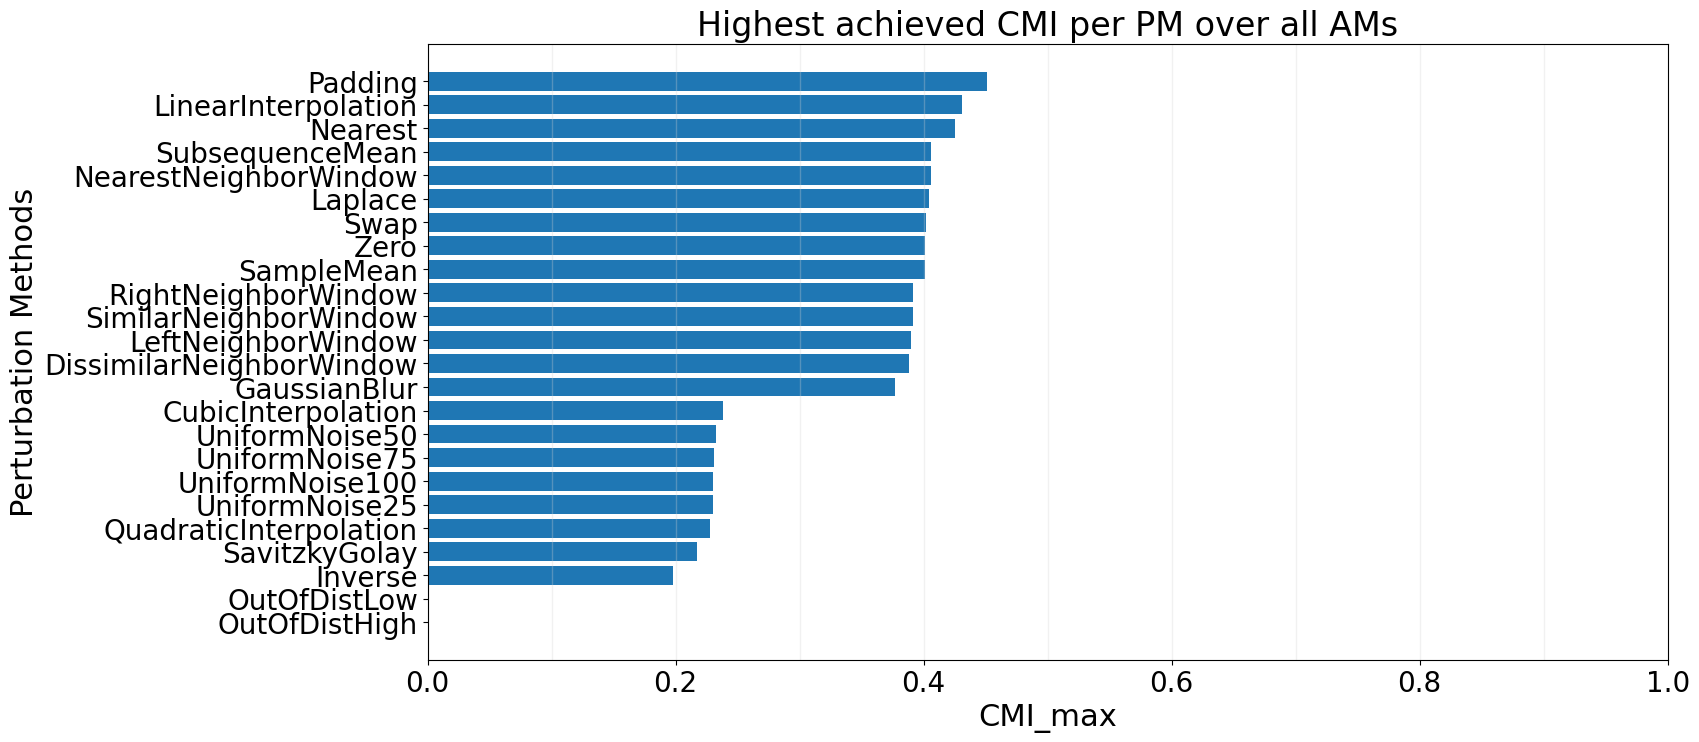

In [14]:

pm_names = results_df['PM'].unique()
pm_cmi_max_results = []
for pm_name in pm_names:
    pm_cmi_max = results_df[results_df['PM'] == pm_name]['CMI'].max()
    pm_cmi_max_results.append(pm_cmi_max)

sorted_data = sorted(zip(pm_cmi_max_results, pm_names), reverse=False)  # Sort in descending order
pm_cmi_max_results, pm_names = zip(*sorted_data)

# Scale all fonts globally
base_font_size = 20
plt.rc('font', size=base_font_size)  # Default font size for all text
plt.rc('axes', titlesize=base_font_size+4)  # Font size of axes title
plt.rc('axes', labelsize=base_font_size+2)  # Font size of x and y labels
plt.rc('xtick', labelsize=base_font_size)  # Font size of x-axis tick labels
plt.rc('ytick', labelsize=base_font_size)  # Font size of y-axis tick labels
plt.rc('legend', fontsize=base_font_size)  # Font size of legend
plt.rc('figure', titlesize=base_font_size+6)  # Font size of figure title

# plt.figure(figsize=(16, 6))
plt.figure(figsize=(16, 8))
plt.barh(pm_names, pm_cmi_max_results)



# Add labels and title
plt.xlabel('CMI_max')
plt.ylabel('Perturbation Methods')
plt.title('Highest achieved CMI per PM over all AMs')
plt.xlim(0,1)

for i in range(10):
    # ax.axvline(x=i, color='gray', linestyle='dashed', alpha=0.2)
    plt.axvline(x=i/10, color='lightgray', alpha=0.3, linewidth=1)

# Display the plot
plt.show()

### Compute CMI-weighted AM ranks

In [15]:
from statsmodels.stats.weightstats import DescrStatsW

am_ranks = {}
for pm_name in pm_names:
    pm_df = results_df[results_df['PM'] == pm_name]
    pm_df = pm_df.sort_values('CMI', ascending=False)
    pm_cmi_max = pm_df['CMI'].max()
    
    rank_counter = 1
    for idx, row in pm_df.iterrows():
        am = row['AM']
        rank = rank_counter
        rank_counter += 1
        if am not in am_ranks:
            am_ranks[am] = {
                'ranks' : [],
                'max_cmis' : []
            }

        am_ranks[am]['ranks'].append(rank)
        am_ranks[am]['max_cmis'].append(pm_cmi_max)

ams = []
weighted_mean_ranks = []
weighted_stds = []
for am in am_ranks:
    ranks = np.array(am_ranks[am]['ranks'])
    weights = np.array(am_ranks[am]['max_cmis'])**2 # squared cmi_max of each ranking

    weighted_avg = DescrStatsW(ranks, weights=weights, ddof=0).mean
    weighted_std = DescrStatsW(ranks, weights=weights, ddof=0).std

    ams.append(am)
    weighted_mean_ranks.append(weighted_avg)
    weighted_stds.append(weighted_std)

# print()
# print(ams)
# print(weighted_mean_ranks)
# print(weighted_stds)

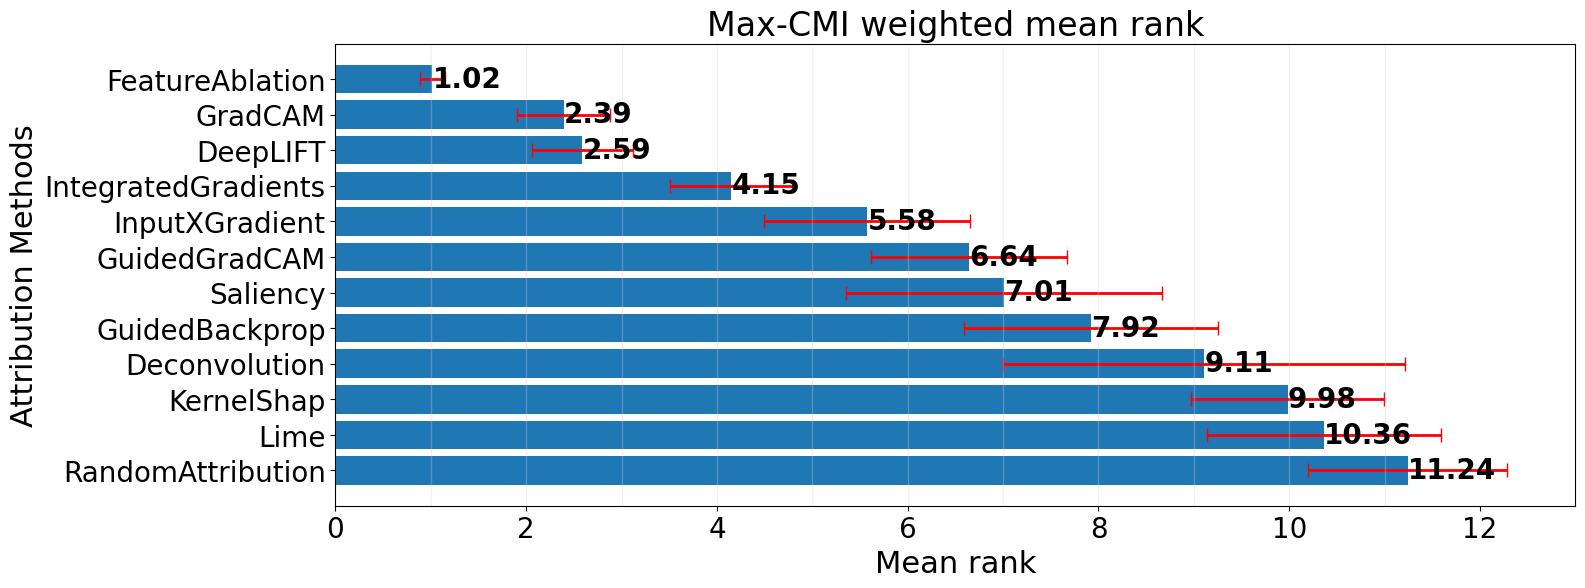

In [16]:
sorted_data = sorted(zip(weighted_mean_ranks, weighted_stds, ams), reverse=True)  # Sort in descending order
weighted_mean_ranks, weighted_stds, ams = zip(*sorted_data)

# print(ams)
# print(weighted_mean_ranks)
# print(weighted_stds)

plt.figure(figsize=(16, 6))
bars = plt.barh(ams, weighted_mean_ranks)
plt.errorbar(weighted_mean_ranks, range(len(ams)), xerr=weighted_stds, fmt='none', ecolor='red', capsize=5, linewidth = 2)

# Add labels and title
plt.xlabel('Mean rank')
plt.ylabel('Attribution Methods')
plt.title('Max-CMI weighted mean rank')
plt.xlim(0,len(ams)+1)

for i in range(len(ams)):
    plt.axvline(x=i, color='lightgray', alpha=0.3, linewidth=1)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold')

# Display the plot
plt.show()